# Imports

In [200]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, f_oneway

import wrangle_zillow

In [201]:
import importlib
importlib.reload(wrangle_zillow) 

<module 'wrangle_zillow' from '/Users/sinao/codeup-data-science/clustering-excercises/wrangle_zillow.py'>

# Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

## Wrangle

In [202]:
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()

(28982, 19) (12422, 19) (10352, 19)
id
1727539     large
1387261    medium
11677       small
2288172     large
781532      large
            ...  
2274245    medium
673515     medium
2968375    medium
1843709     small
1187175    medium
Name: home_size, Length: 52216, dtype: category
Categories (3, object): ['small' < 'medium' < 'large']
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52216 entries, 1727539 to 1187175
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   bathrooms          52216 non-null  float64 
 1   bedrooms           52216 non-null  float64 
 2   area               52208 non-null  float64 
 3   county             52216 non-null  object  
 4   garagetotalsqft    52216 non-null  float64 
 5   latitude           52216 non-null  float64 
 6   longitude          52216 non-null  float64 
 7   lotsizesquarefeet  51859 non-null  float64 
 8   poolcnt            52216 

## Explore - Univariate

In [203]:
#after eliminated nulls only able to view homes within fips 6037
df.county.value_counts()

LA County         33780
Orange County     14063
Ventura County     4373
Name: county, dtype: int64

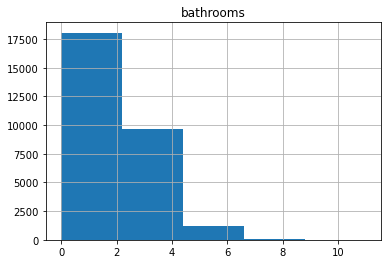

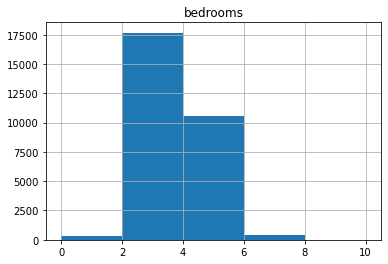

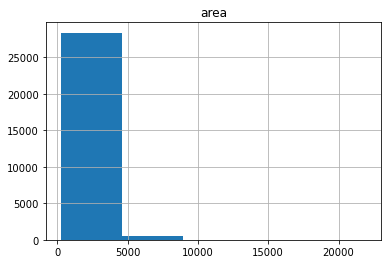

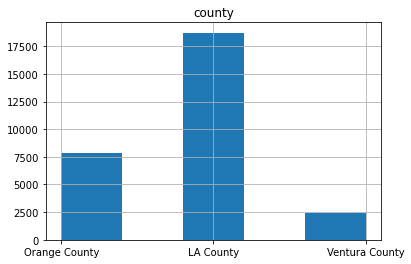

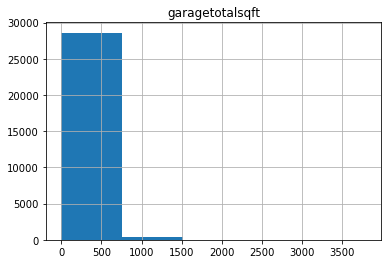

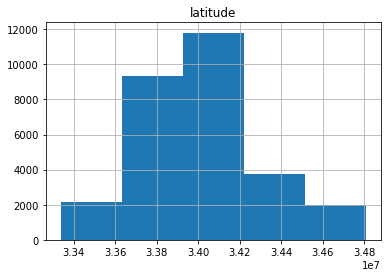

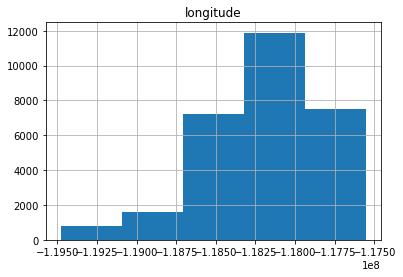

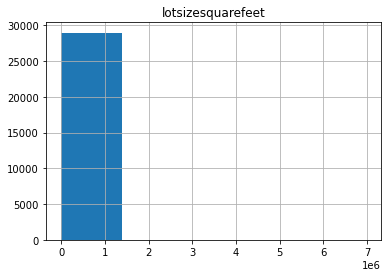

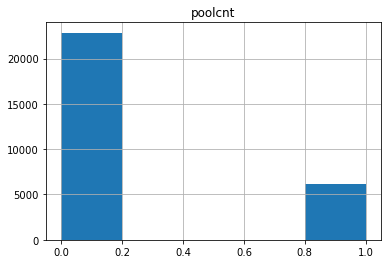

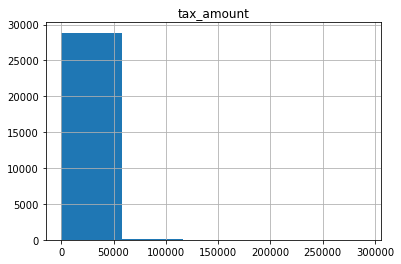

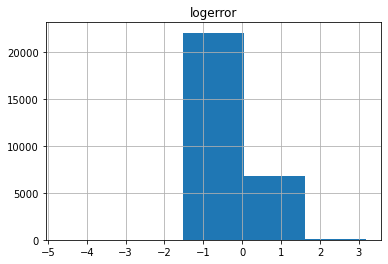

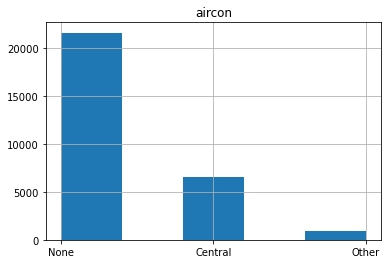

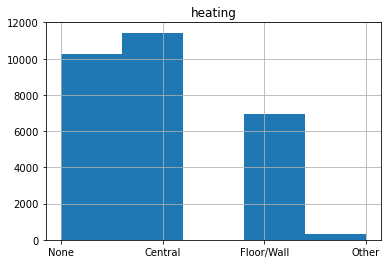

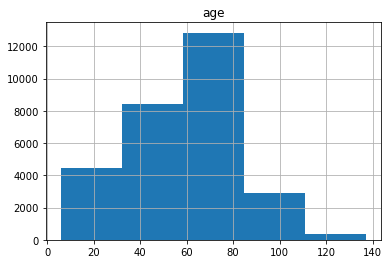

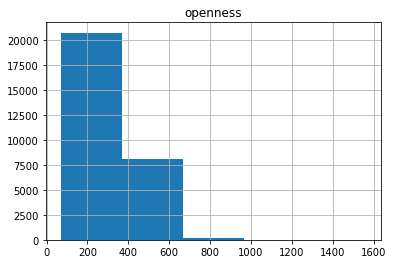

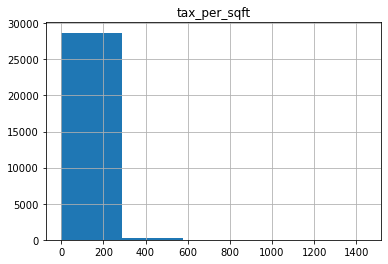

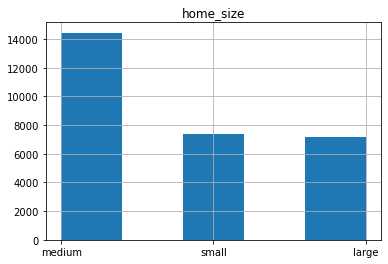

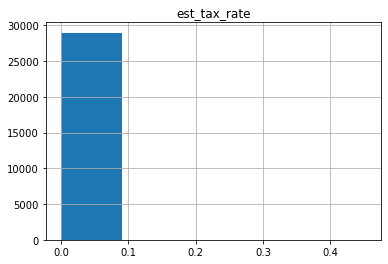

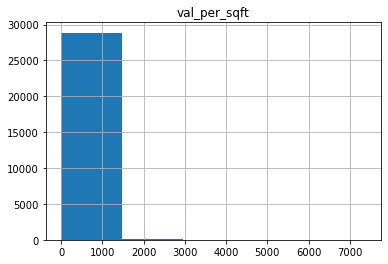

In [204]:
for col in train.columns:
    train[col].hist(bins=5)
    plt.title(col)
    plt.show()


In [205]:
def remove_outliers(df, col_list, k=1.5):
    """ 
    Purpose
        Remove outliers from a list of columns in a dataframe and return that dataframe
    
    Parameters
        df: a dataframe containing zillow real estate data
        k: factor to multiple IQR
        col_list: a list of dataframe columns to work on 

    Returns
        df: a dataframe with the desired adjustments
    """

    # total number of observations
    num_obs = df.shape[0]
        
    # Create a column that will label our rows as containing an outlier. sets default value
    df['outlier'] = False

    # loop through the columns provided to find appropriate values and labels
    for col in col_list:

        # find quartiles
        q1, q3 = df[col].quantile([.25, .75])  
        
       # get interquartile range
        iqr = q3 - q1

       # find upper/lower bounds 
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label as needed. 
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    # set dataframe to dataframe w/o the outliers
    df = df[df.outlier == False]

    # drop the outlier column from the dataFrame. no longer needed
    df.drop(columns=['outlier'], inplace=True)

    # print out number of removed observations
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

In [206]:
num_cols = train.drop(columns='poolcnt').select_dtypes(include=['number']).columns.tolist()
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [207]:
train = remove_outliers(train, num_cols)

Number of observations removed: 11293


/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_91248/2360479568.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['outlier'], inplace=True)


### Takeaways
* skewed (watching for outliers) 
    - bathroomcant, calculatedbathnbr, calculatedfinishedsquarefeet,fnishiedsquarefeet12, lotsizesquarefeet, taxvaluedollarcnt,
    - landtaxvaluedollarcnt, taxamount
* normal 
    - bedroomcnt
* need better visual/further examination  
    -  propertyzoningdesc, unitcnt,
* can possibly drop/change
    - drop (moved to wrangle): unitcnt, roomcnt, regionidcounty, **finishedsquarefeet12**, **fullbathcnt**, assessmentyear, basementsqft
    - change: regionidzip, regionidcity, propertylandusecode, fips, yearbuilt, rawcensustractandblock

---------------
* 

Explore - Bivariate 
* Everything vs. logerror

In [208]:
train['abs_error'] = abs(train.logerror)
train_scaled['abs_error'] = abs(train_scaled.logerror)

/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_91248/3779083013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['abs_error'] = abs(train.logerror)


In [209]:
train.logerror

id
2175279    0.010740
717534     0.005669
2779077   -0.015602
2190830    0.027932
1921201   -0.046565
             ...   
725846    -0.062378
236546     0.048095
2484236   -0.021177
2153481    0.093306
2382053    0.016438
Name: logerror, Length: 17689, dtype: float64

In [210]:
train['pos/neg error'] = train['logerror'].apply(lambda x: 'positive' if x >= 0 else 'negative')

/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_91248/3089752545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pos/neg error'] = train['logerror'].apply(lambda x: 'positive' if x >= 0 else 'negative')


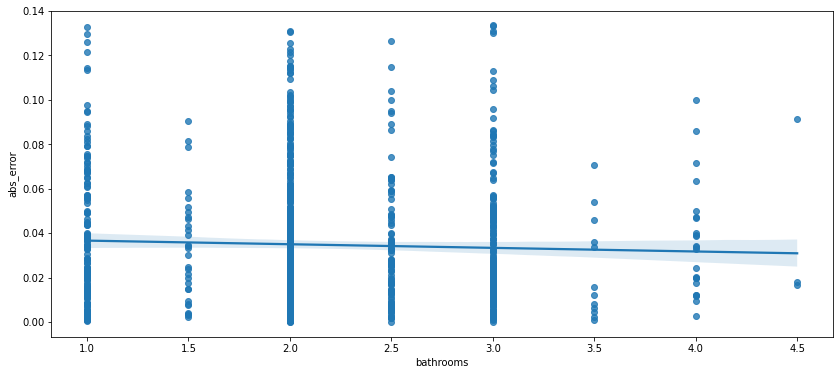

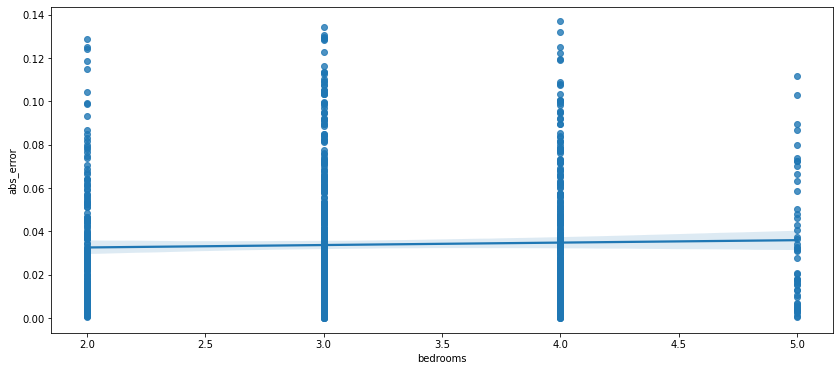

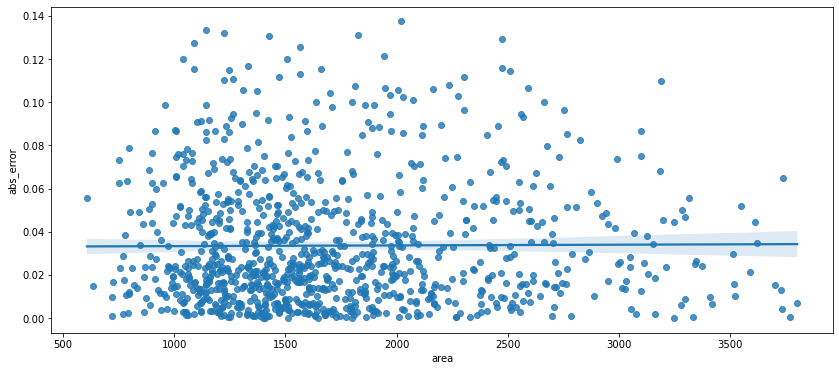

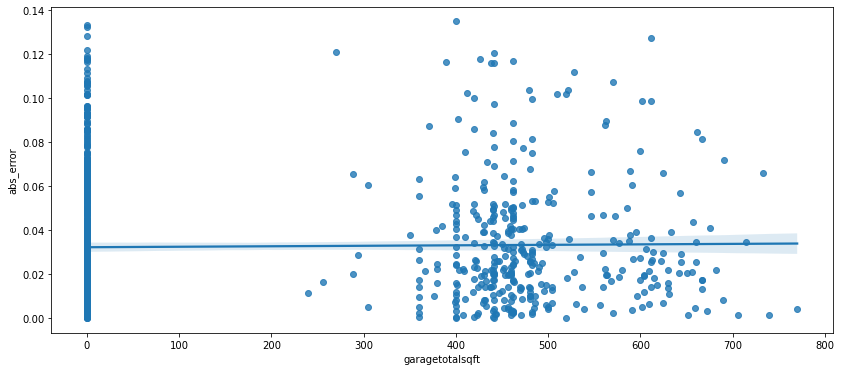

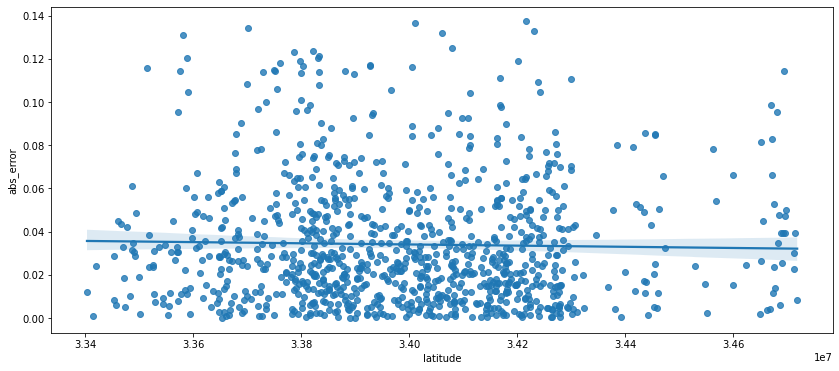

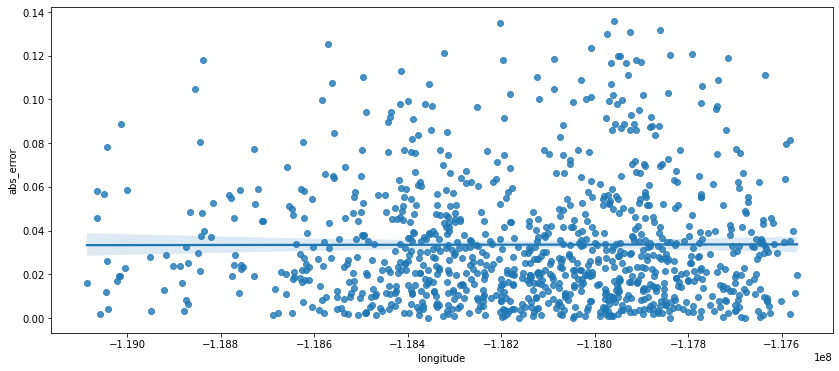

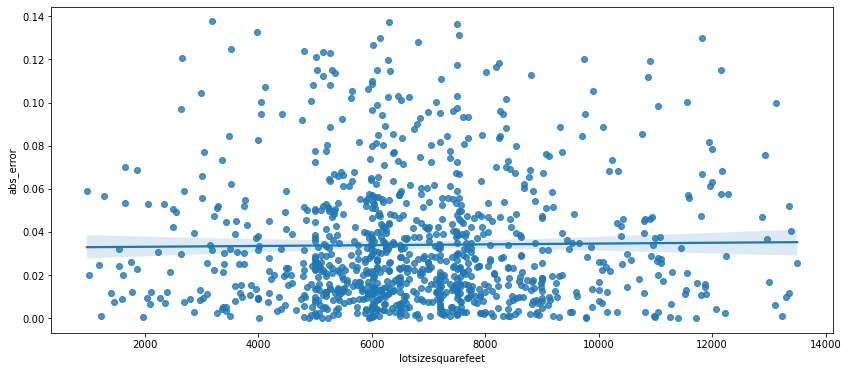

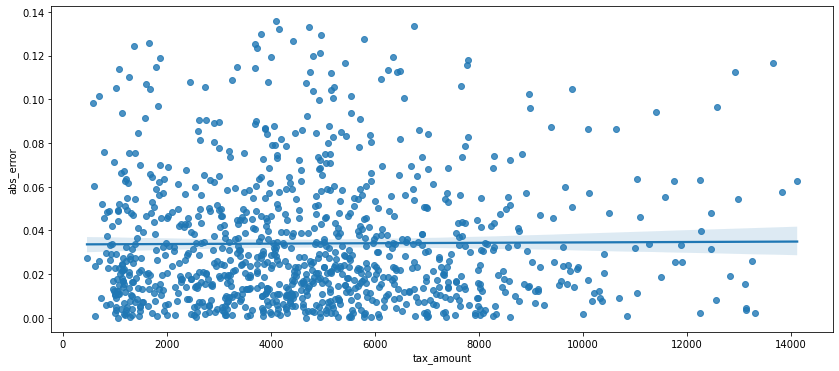

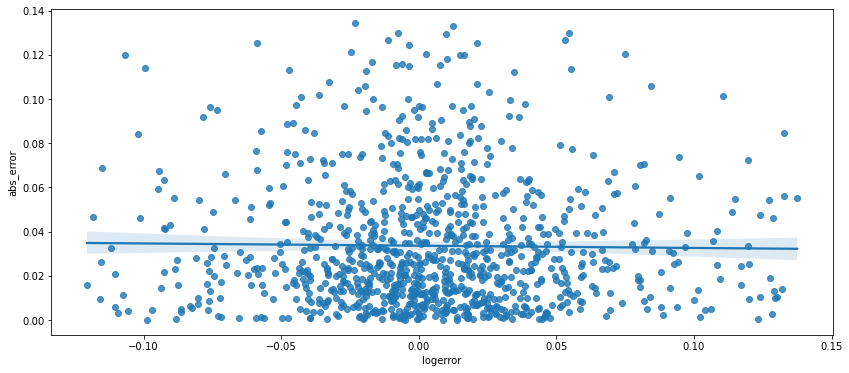

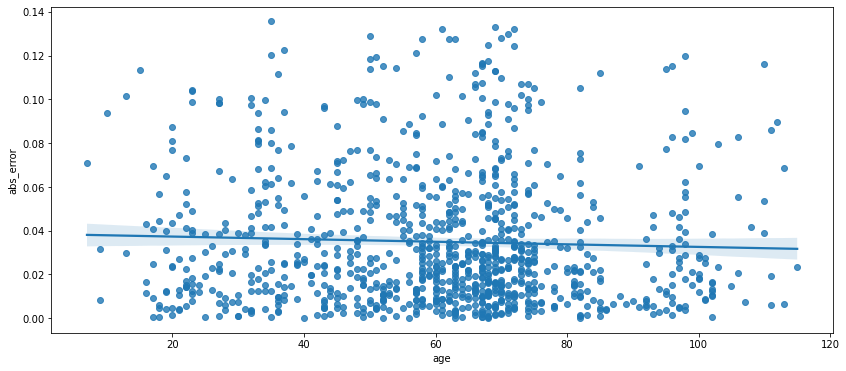

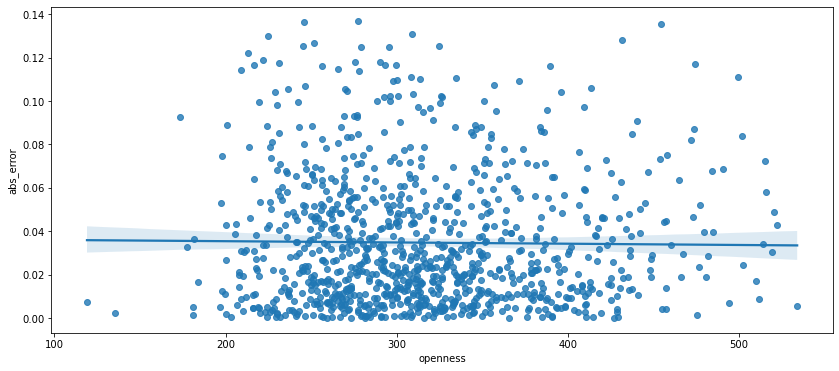

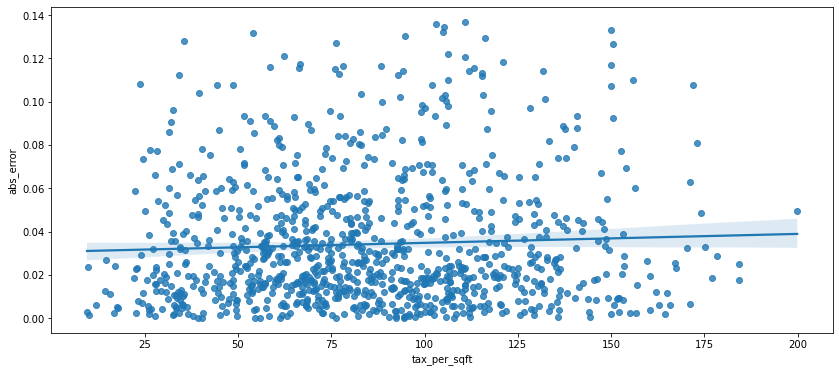

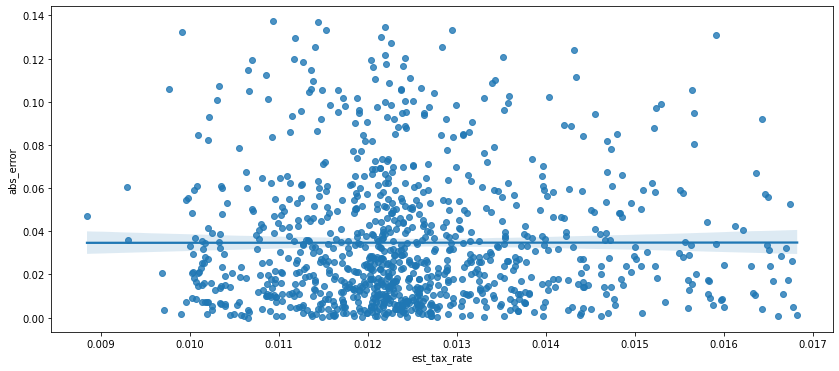

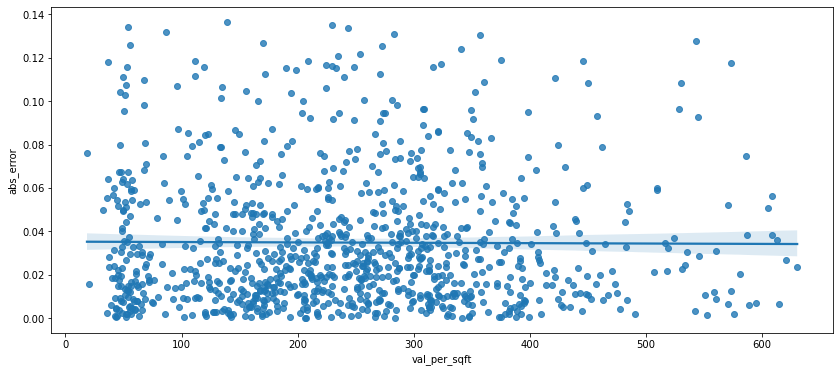

In [211]:
for col in num_cols:
    plt.figure(figsize=(14,6))
    sns.regplot(data=train.sample(n=1000), x=train[col].sample(n=1000), y='abs_error')
    # m, b = np.polyfit(train[col].sample(n=1000), train['abs_error'].sample(n=1000), 1)
    # print(m)
    plt.show()

<Figure size 1008x432 with 0 Axes>

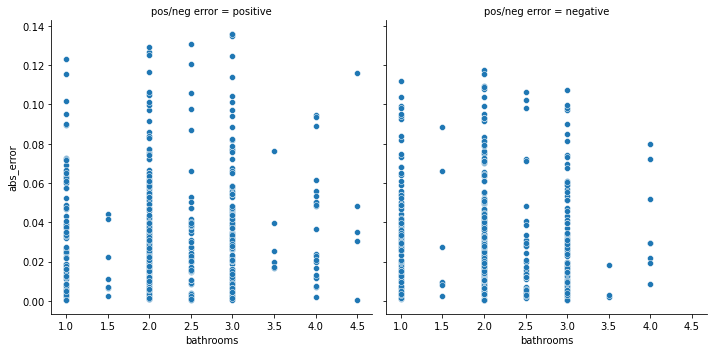

<Figure size 1008x432 with 0 Axes>

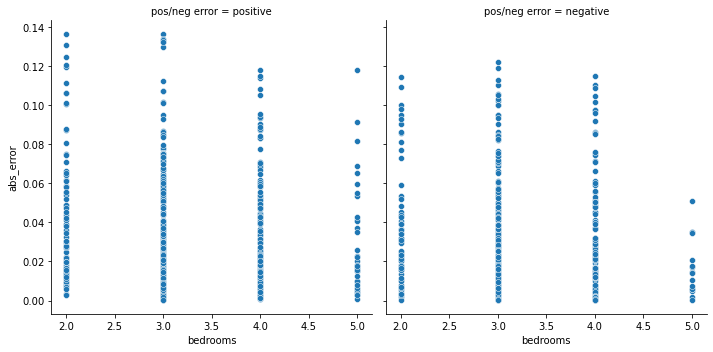

<Figure size 1008x432 with 0 Axes>

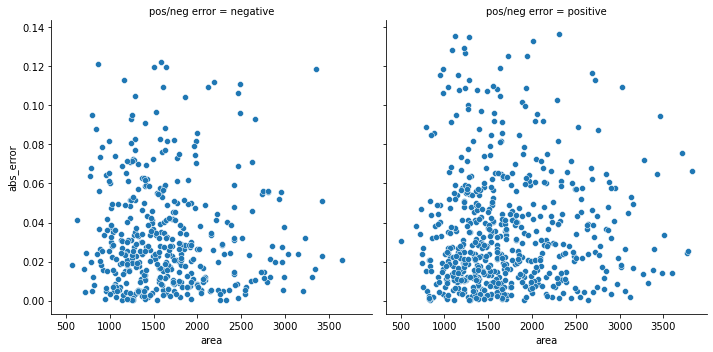

<Figure size 1008x432 with 0 Axes>

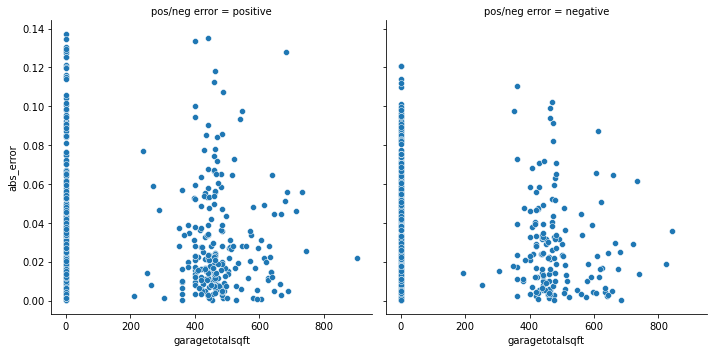

<Figure size 1008x432 with 0 Axes>

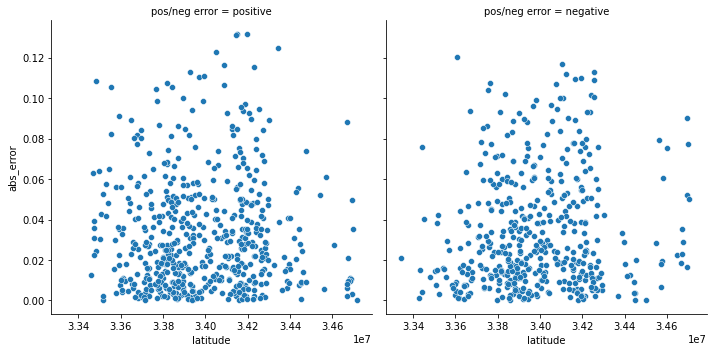

<Figure size 1008x432 with 0 Axes>

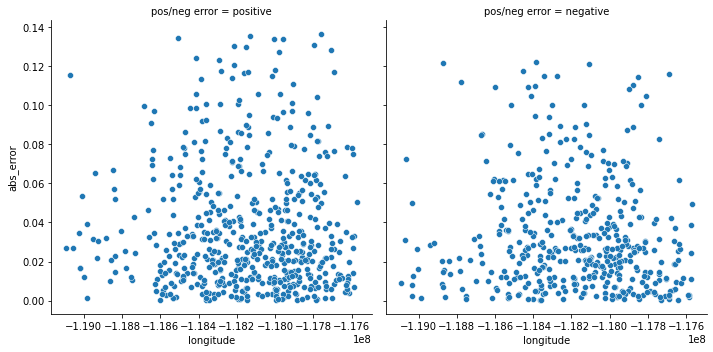

<Figure size 1008x432 with 0 Axes>

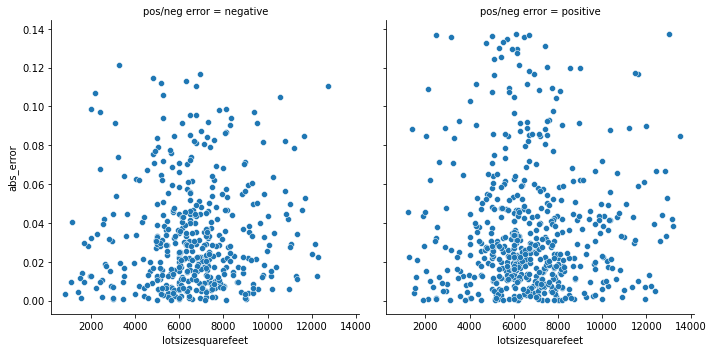

<Figure size 1008x432 with 0 Axes>

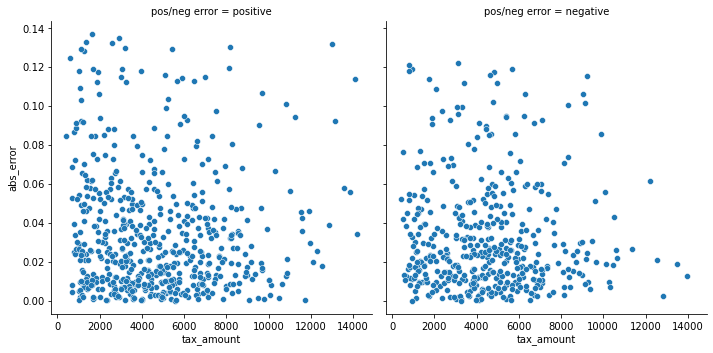

<Figure size 1008x432 with 0 Axes>

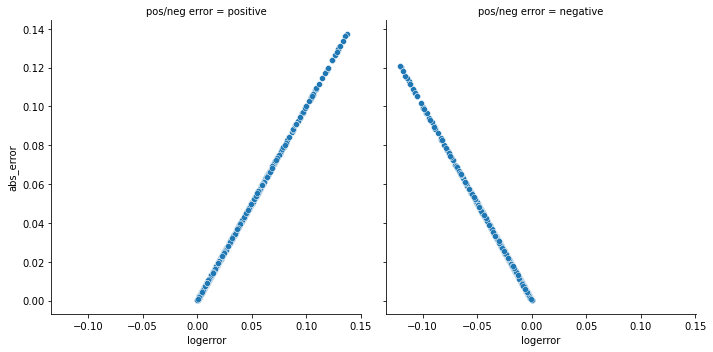

<Figure size 1008x432 with 0 Axes>

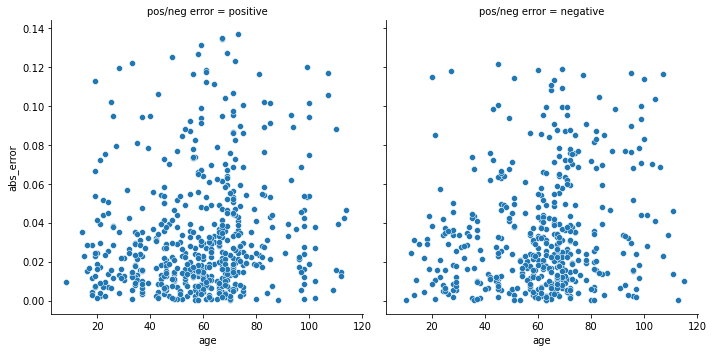

<Figure size 1008x432 with 0 Axes>

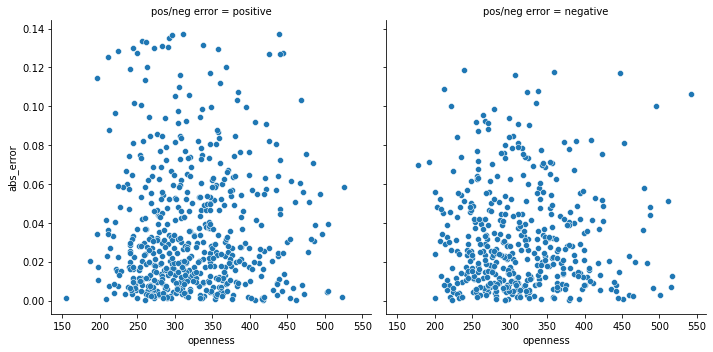

<Figure size 1008x432 with 0 Axes>

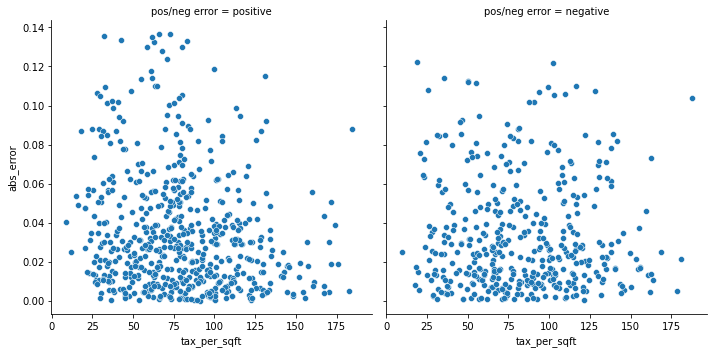

<Figure size 1008x432 with 0 Axes>

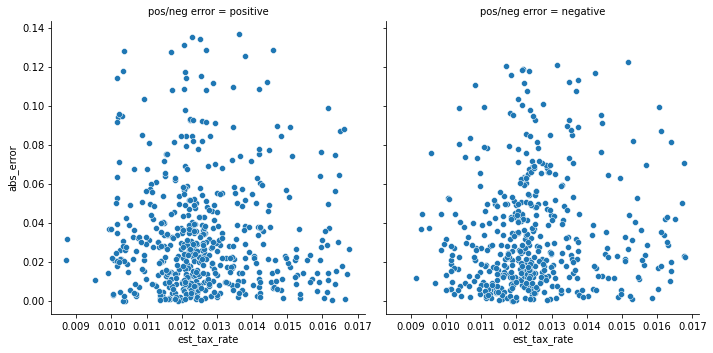

<Figure size 1008x432 with 0 Axes>

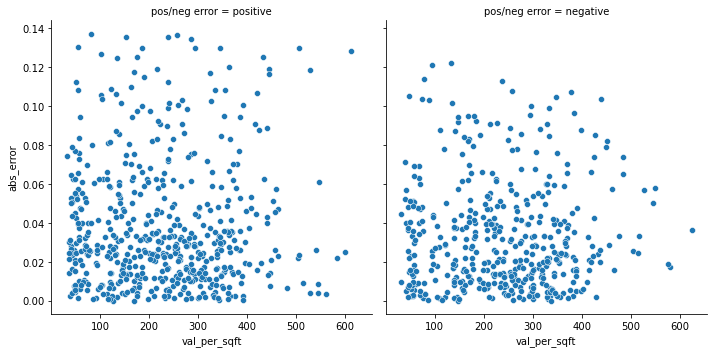

In [212]:
for col in num_cols:
    plt.figure(figsize=(14,6))
    sns.relplot(data=train.sample(n=1000), x=train[col], y='abs_error', col='pos/neg error')
    plt.show()

### Takeaways - Numeric Columns
* May want to create a new column that is the absolute value of the log error, and then another cat that says negative or positive error
* Need to check back and get rid of roomcnt, and a unitcnt 
* Greater errors
    - less bathrooms, moderate bedrooms

## Box Plot


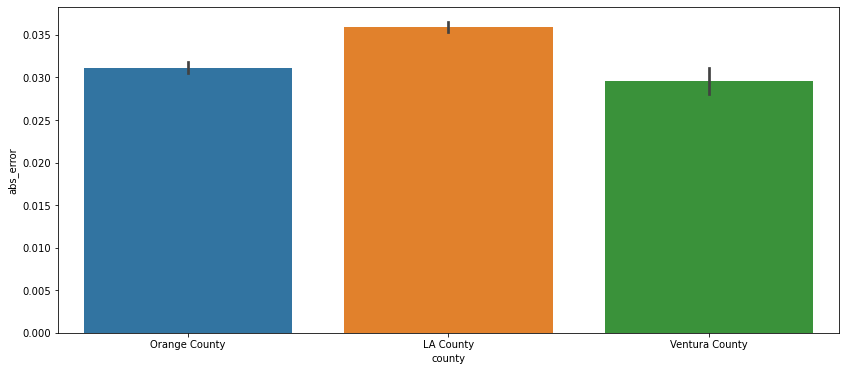

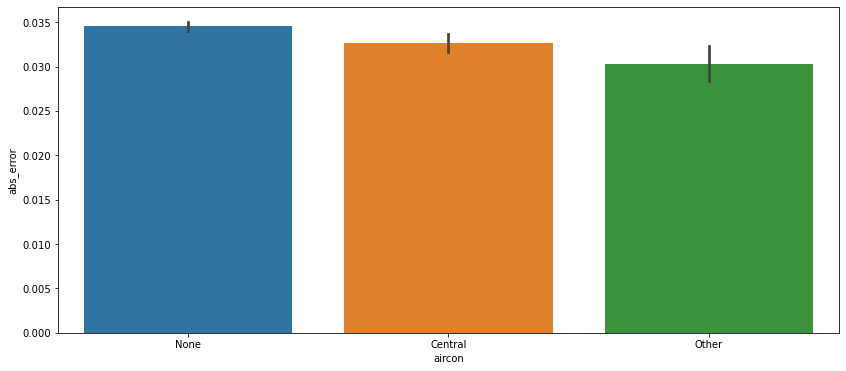

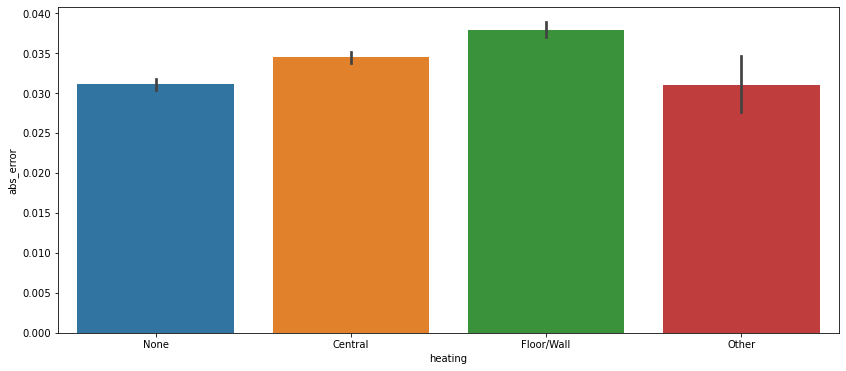

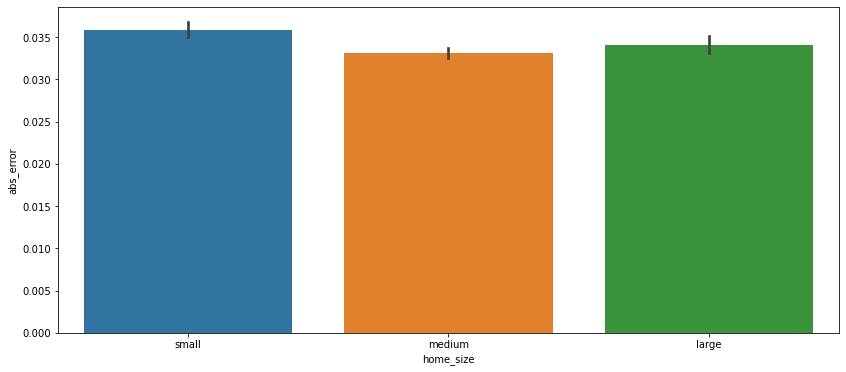

In [213]:
for col in cat_cols:
    plt.figure(figsize=(14,6))
    sns.barplot(data=train, x=train[col], y='abs_error')
    plt.show()

### Takeaways - Categorical
* Need to figure out what to do with census , regionidzip, regionidcity, propertyzoning desc
* higher absolute log errors in houses with floor/wall heating than other types

In [214]:
#code to try and put in cities by zip
# train.regionidzip.value_counts()
# train.regionidcity.value_counts()
# zip_codes = pd.read_csv('zip_codes.csv')
# zip_codes = zip_codes.rename(columns={'LOS ANGELES CITIES': 'City'})
# zip_codes = zip_codes.melt(id_vars=['City'])
# zip_codes = zip_codes.drop(columns='variable')
# zip_codes = zip_codes.dropna()
# pd.concat([train[['regionidzip']], zip_codes], join='outer')
# zip_codes = zip_codes.rename(columns={'value':'regionidzip'})
# train.regionidzip.value_counts()

<AxesSubplot:>

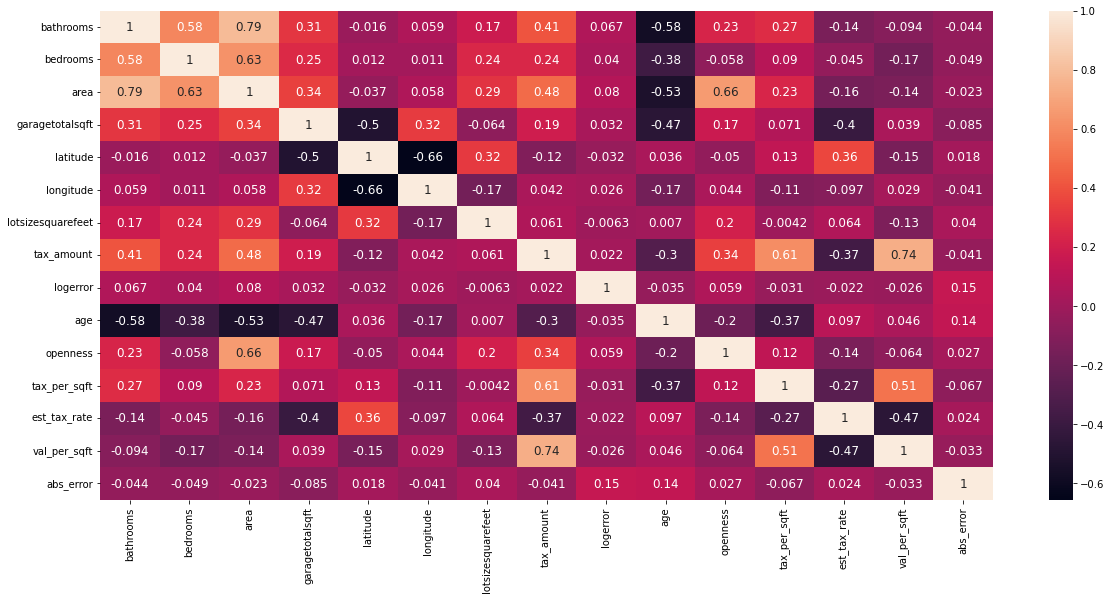

In [215]:
plt.figure(figsize=(20,9))
corr = train.drop(columns='poolcnt').corr()
sns.heatmap(corr, annot=True, annot_kws={"size":12})


#### Takeaways
* Basically useless
* the absolute error doesn't tell us much. ver minimal correlation with any category
    - investigate age, bathrooms,  tax_per_sqft, and val_per_sqft

## Q1 - Differences between mean absolute error between different ages

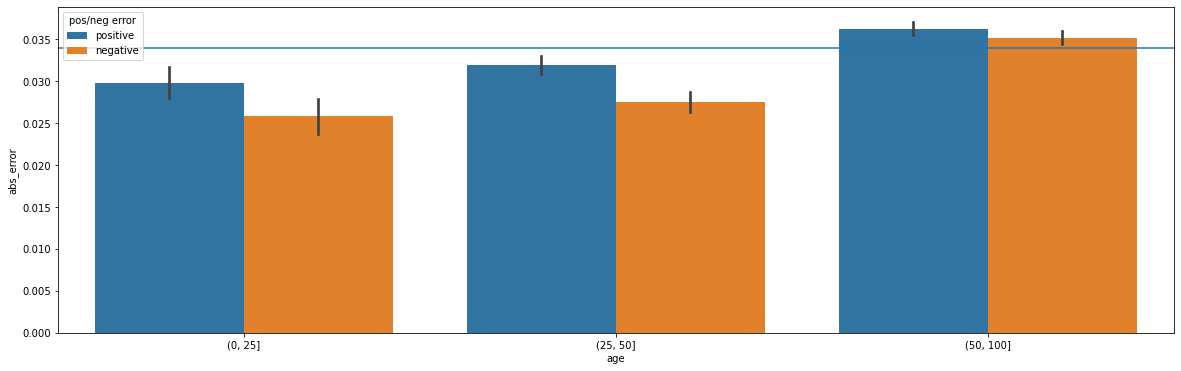

In [216]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, x=pd.cut(train.age, [0, 25, 50, 100]), y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

### Takeaway
* slight changes as homes get older. try using smaller bins
* range in error increates as homes age further than 50 years
* Will follow this with check for correlation

## Q2 - Is there correlation between age and absolute error value?

<Figure size 1440x432 with 0 Axes>

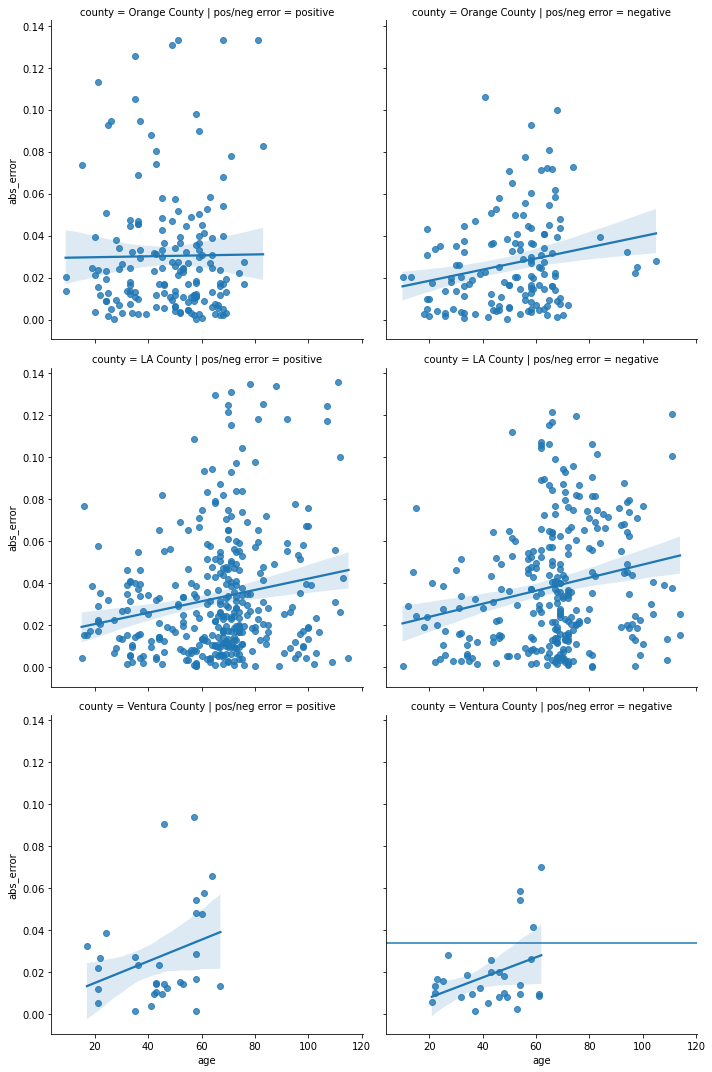

In [224]:
plt.figure(figsize=(20,6))
sns.lmplot(data=train.sample(n=1000), x='age', y='abs_error', col='pos/neg error', row='county')
plt.axhline(y = train.abs_error.mean())

In [228]:
#Testing
#hypothesis 
# H0: no difference 
# Ha: significantly larger
# alpha = .05
alpha = .05

for county in ['LA County', 'Orange County', 'Ventura County']:
    print(f'-----\nIn {county}:')
    r, p = pearsonr(train_scaled[train_scaled.county == county].age, train_scaled[train_scaled.county == county].abs_error)
    print (f'Pearson r value: {r}')
    print (f'p-value : {p}')

    if p > alpha:
        print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
    else: 
        print(f'There is enough evidence to reject our null hypothesis')

-----
In LA County:
Pearson r value: 0.09763429658087402
p-value : 6.961694891095473e-41
There is enough evidence to reject our null hypothesis
-----
In Orange County:
Pearson r value: 0.0574287460233097
p-value : 3.63679780330461e-07
There is enough evidence to reject our null hypothesis
-----
In Ventura County:
Pearson r value: 0.08472109091744226
p-value : 2.9375684731618745e-05
There is enough evidence to reject our null hypothesis


### Takeaways 
* Visualizations
    - First visualation showed apparant difference in 
    - 2nd Visualization: Possibly greater correlation in Centura country
* Statistical Testing
    - Very Low r value, but confirmed correlation. I will also split by county and see if that makes a difference
    - When split by counties r value still extremely low, but correlation is confirmed
    - Greater in LA County and Ventura County

## Q3 - Differences between mean absolute error and diffferent home sizes

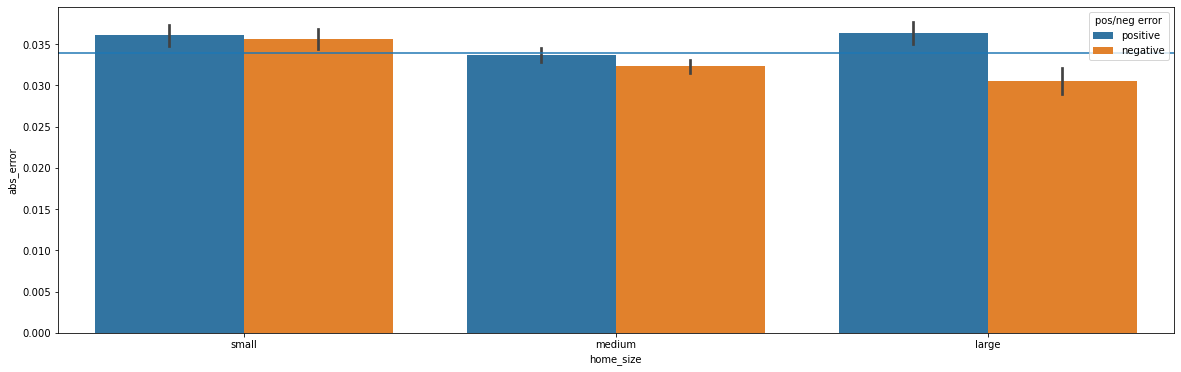

In [219]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, 
    x='home_size',
    y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

## Q4 - Differences in mean absolute error between different numbers of bedrooms

<Figure size 1440x432 with 0 Axes>

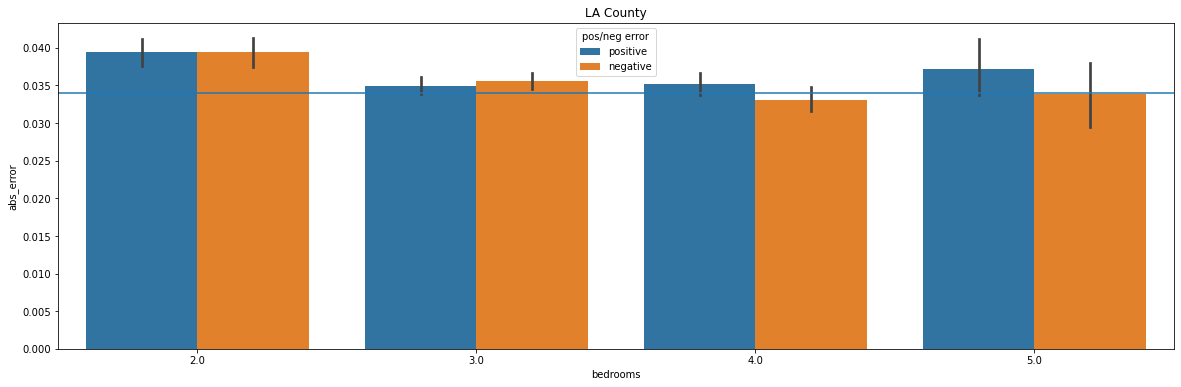

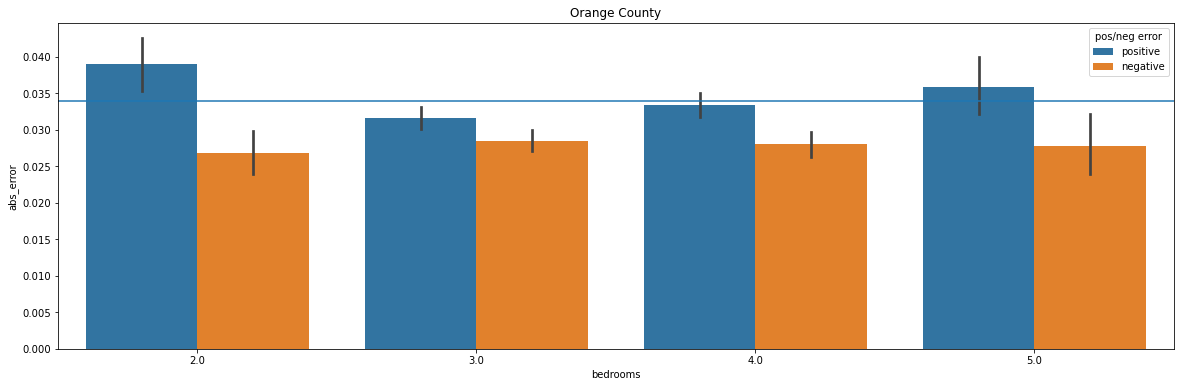

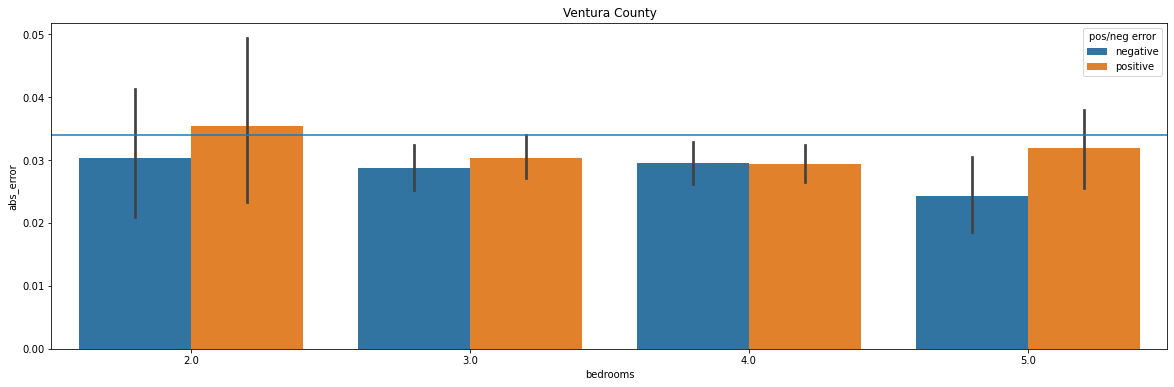

In [235]:
plt.figure(figsize=(20,6))

for county in ['LA County', 'Orange County', 'Ventura County']:
    plt.figure(figsize=(20,6))
    sns.barplot(data=train[train.county == county], x='bedrooms', y='abs_error', hue='pos/neg error')
    plt.axhline(y = train.abs_error.mean())
    plt.title(county)
    plt.show()

### Takeaways
* Nothing big here as at first blush. Relationship does not seem to reflect consistent relationship
* Will run second visual with them split by counties to see if it tracks with the differences of mean log error between different sized homes in different counties
* Ventura seems more consistanly below the mean. Will further investigate

## Q5 - Differences in mean absolute error among the different counties?

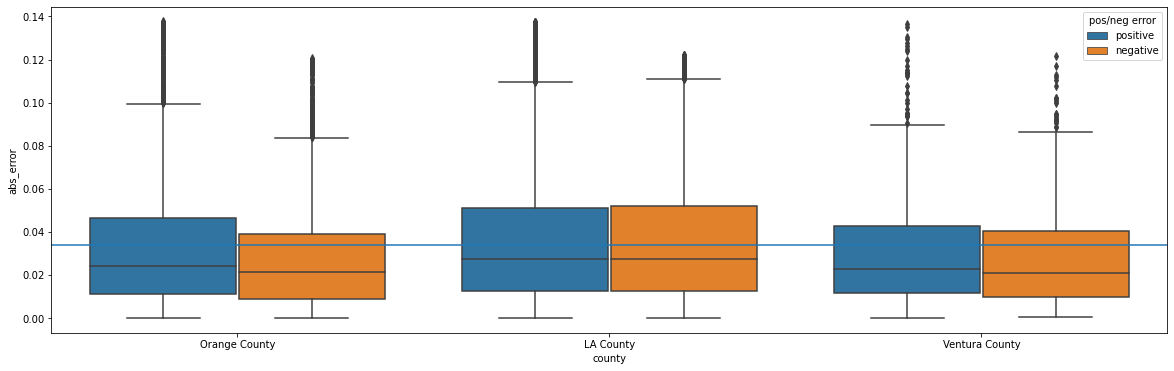

In [221]:
plt.figure(figsize=(20,6))
sns.boxplot(data=train, 
    x='county',
    y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

In [222]:
train.groupby(['county', 'pos/neg error', 'home_size'])['abs_error'].mean()

county          pos/neg error  home_size
LA County       negative       small        0.037160
                               medium       0.035214
                               large        0.033927
                positive       small        0.036551
                               medium       0.035152
                               large        0.038647
Orange County   negative       small        0.029894
                               medium       0.027511
                               large        0.028483
                positive       small        0.035097
                               medium       0.032194
                               large        0.035009
Ventura County  negative       small        0.031758
                               medium       0.029107
                               large        0.025994
                positive       small        0.031635
                               medium       0.029073
                               large        0.032050
Name:

In [223]:
#Testing
#hypothesis 
# H0: no difference 
# Ha: significantly larger
# alpha = .05
alpha = .05
l_a = train_scaled[train_scaled.county == 'LA County'].abs_error
orange = train_scaled[train_scaled.county == 'Orange County'].abs_error
ventura = train_scaled[train_scaled.county == 'Ventura County'].abs_error
f, p = f_oneway(l_a, orange, ventura)

print (f'ANOVA test statistic value: {f}')
print (f'p-value : {p}')

if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

ANOVA test statistic value: 16.8894795585422
p-value : 0.0
There is enough evidence to reject our null hypothesis


In [229]:
#Testing
#hypothesis 
# H0: no difference 
# Ha: significantly larger
# alpha = .05
alpha = .05
l_a = train_scaled[train_scaled.county == 'LA County'].logerror
orange = train_scaled[train_scaled.county == 'Orange County'].logerror
ventura = train_scaled[train_scaled.county == 'Ventura County'].logerror
f, p = f_oneway(l_a, orange, ventura)

print (f'ANOVA test statistic value: {f}')
print (f'p-value : {p}')

if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

ANOVA test statistic value: 13.155209672261055
p-value : 1.9469599739625273e-06
There is enough evidence to reject our null hypothesis


### Takeaway
* Visualization
    - LA County seems to have a larger proprotion of homes above the mean abs value long erro, both positive and negative. Ventura County with the least
* Statistical Analysis
    - The movement of abs value log error is different among the counties as home size increases
    - In Ventura - negative errors decrease  as size goes up with the inverse being true for positive. Simliar relationship in th eother counties
    - More intersting test may be to see if their is a relationship between the positive or negative status of a log error and it's size
* Statistical Testing
    - Difference between counties confirmed with Anova test. 

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.


